In [99]:
!pip install langchain langchain_google_genai langchain_community langgraph

In [100]:
from google.colab import userdata
Google_api_key=userdata.get('GEMINI-API-KEY')

In [101]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import TavilySearchResults

In [102]:
Model = ChatGoogleGenerativeAI(model='gemini-2.5-flash',api_key=Google_api_key)
Model.invoke("Hey how are you?").content

"I'm doing well, thank you for asking!\n\nHow about you?"

In [103]:
pip install langchain-twitter tweepy

In [105]:
# from tweepy import Client
# from langchain_core.tools import tool
# import os


# @tool
# def post_tweet(tweet: str) -> str:
#     """
#     Post a tweet with the given text.
#     Returns the tweet ID or a URL.
#     """
#     client = Client(
#         bearer_token=twitter_bearer_token,
#         consumer_key=twitter_api_key,
#         consumer_secret=twitter_secret_key,
#         access_token=twitter_acess_token,
#         access_token_secret=twitter_acess_token_secret,
#     )

#     try:
#         response = client.create_tweet(text=tweet)
#         tweet_id = response.data["id"]
#         return f"Tweet posted successfully:- URL: https://twitter.com/user/status/{tweet_id}"
#     except Exception as e:
#         return f"Error posting tweet: {str(e)}"

# #test it
# post_tweet.invoke("Hello world! This tweet was posted by my LangChain agent.")

In [106]:
# @tool
# def delete_tweet(tweet_id: str) -> str:
#     """
#     Delete a tweet with the given ID.
#     Returns a success message or an error message.
#     """
#     client = Client(
#         bearer_token=twitter_bearer_token,
#         consumer_key=twitter_api_key,
#         consumer_secret=twitter_secret_key,
#         access_token=twitter_acess_token,
#         access_token_secret=twitter_acess_token_secret,
#     )
#     try:
#       deleted_tweet = client.delete_tweet(id=tweet_id)
#       if deleted_tweet.data.get("deleted",False):
#         return f"Tweet deleted successfully:- URL: https://twitter.com/user/status/{tweet_id}"
#       else:
#         return f"Failed to delete tweet {tweet_id}. Response: {deleted_tweet.data}"
#     except Exception as e:
#         return f"Error deleting tweet: {str(e)}"

# delete_tweet.invoke('1978113099698995651')

In [107]:
# @tool
# def update_tweet_node(tweet_id: str, new_text: str):
#     """
#     Simulates updating a tweet: shows old tweet, deletes, posts new text.
#     """
#     client = Client(
#         bearer_token=twitter_bearer_token,
#         consumer_key=twitter_api_key,
#         consumer_secret=twitter_secret_key,
#         access_token=twitter_acess_token,
#         access_token_secret=twitter_acess_token_secret,
#     )
#     try:
#       old_tweet = client.get_tweet(tweet_id)
#       old_text = old_tweet.data.get("text")
#       print(old_text)
#       delete_resp = client.delete_tweet(tweet_id)
#       if not delete_resp.data.get("deleted", False):
#           return f"Failed to delete old tweet {tweet_id}"
#       new_resp = client.create_tweet(text=new_text)
#       new_id = new_resp.data["id"]
#       return f"Tweet updated successfully! New tweet ID: {new_id}"
#     except Exception as e:
#       return f"Error updating tweet: {str(e)}"

# #testing
# update_tweet_node.invoke({
#     "tweet_id": "1978122728747282559",
#     "new_text": "hello im waris and doing this by ai automation"
# })

In [108]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated,Literal,Dict,List

class TweetState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    topic: str
    call: Literal['chat_side', 'twitter_side']
    genrated_tweet: str
    posted_tweet: Dict[str, str]
    deleted_tweet: List[str]
    updated_tweet: Dict[str, str]
    node_call: Literal['posted_tweet', 'deleted_tweet', 'updated_tweet']
    tweet_id: str

In [109]:
from pydantic import BaseModel,Field

class chat_decider(BaseModel):
  call : Literal['chat_side','twitter_side'] = Field(description="based on user input you will decide this is genral chat or this is twitter_side related chat")


class TweetDecider(BaseModel):
  node : Literal['posted_tweet','deleted_tweet','updated_tweet'] = Field(description="based on the node you will answer from one of these 'posted_tweet','deleted_tweet','updated_tweet'")

TweetDeciderModel = Model.with_structured_output(TweetDecider)
ChatDeciderModel = Model.with_structured_output(chat_decider)

In [110]:
ChatDeciderModel.invoke("write something trending on machine learning and post it").call

'twitter_side'

In [111]:
from langgraph.graph import StateGraph,START,END
graph = StateGraph(TweetState)

In [112]:
def decide_chat_router(state: TweetState):
    topic = state['topic'][-1]
    prompt = f"""
    You are an expert AI assistant.
    Decide whether this input relates to Twitter actions (post/update/delete) or is general chat.

    Output only:
    - "twitter_side"
    - "chat_side"

    User input: "{topic}"
    """
    msg = [
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content=prompt)
    ]

    try:
        response = ChatDeciderModel.invoke(msg)
        decider = getattr(response, "call", None)
        if not decider and isinstance(response, dict):
            decider = response.get("call")

        if decider in ["chat_side", "twitter_side"]:
            state["call"] = decider
        else:
            state["messages"].append(AIMessage(content=f"Unexpected decider output: {response}"))
            state["call"] = "chat_side"
    except Exception as e:
        state["messages"].append(AIMessage(content=f"Error in decide_chat_router: {str(e)}"))
        state["call"] = "chat_side"

    return state


In [113]:
def Tweet_update_node(state: TweetState) -> TweetState:
    """
    Revise and improve the generated tweet to make it more engaging.
    Updates the state with the revised tweet.
    """
    # Check if we have generated tweets
    if not state.get('generated_tweet') or not state['generated_tweet']:
        state['messages'].append(AIMessage(content="No generated tweet available to update."))
        return state

    # Check if we have topic
    if not state.get('topic') or not state['topic']:
        state['messages'].append(AIMessage(content="No topic available for context."))
        return state

    latest_tweet = state['generated_tweet'][-1]
    topic = state['topic'][-1]

    prompt = f"""
    You are an expert social media AI assistant.
    Your task is to revise and improve the following tweet based on the original topic.

    Topic: `{topic}`
    Original Tweet: `{latest_tweet}`

    Requirements:
    - Keep it under 280 characters.
    - Make the revision more engaging and conversational.
    - Improve clarity and impact.
    - Maintain the original meaning.

    Provide the revised tweet text only.
    """
    sys_msg = "You are a helpful assistant."
    msg = [
        SystemMessage(content=sys_msg),
        HumanMessage(content=prompt)
    ]
    try:
        update_tweet = Model.invoke(msg).content

        if update_tweet:
            state['generated_tweet'].append(update_tweet)
            state['messages'].append(AIMessage(content=f"Tweet updated successfully! New version: {update_tweet}"))
        else:
            state['messages'].append(AIMessage(content="Failed to generate updated tweet."))

    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error updating tweet: {str(e)}"))

    return state

In [114]:
def Tweet_genration_node(state: TweetState) -> TweetState:
    topic = state['topic'][-1]

    system_msg = "You are an expert social media AI assistant."
    prompt = f"""
    Generate a creative, engaging, and short tweet about the following topic:

    Topic: '{topic}'

    Requirements:
    - Maximum 280 characters.
    - Avoid hashtags unless very relevant.
    - Keep it informative, friendly, and concise.
    - Output only the tweet text. No extra commentary.
    """

    msg = [
        SystemMessage(content=system_msg),
        HumanMessage(content=prompt)
    ]

    try:
        tweet = Model.invoke(msg).content
        if tweet:
            state['genrated_tweet'].append(tweet)
        else:
            state['messages'].append(AIMessage(content="Failed to generate tweet."))
    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error generating tweet: {str(e)}"))

    return state


In [115]:
def decide_tweeter_position(state: TweetState):
    topic = state['topic'][-1]
    prompt = f"""
      You are an expert social media AI assistant.
      Your task is to decide which node should be called based on the user's query or topic.
      The available nodes are:
      - post_node
      - delete_node
      - update_node

      User query/topic: `{topic}`

      Instructions:
      - Analyze the query carefully.
      - Choose only one node that is most appropriate for the action the user wants to perform.
      - Return the node name only, nothing else.
"""
    system_msg = "You are a helpful assistant."
    msg = [
        SystemMessage(content=system_msg),
        HumanMessage(content=prompt)]
    result = TweetDeciderModel.invoke(msg).node
    if result:
      state['node_call'] = result
      return state
    else:
      state['messages'].append(AIMessage(content="Failed to decide the next step."))
      return state


In [116]:
def genral_chat(state: TweetState) -> TweetState:
    question = state['topic']
    history = state['messages']
    history.append(HumanMessage(content=question))
    system_msg = "You are a helpful assistant."
    user_prompt = f"You are helpful assistant based on user query: '{history}'. Provide a simple, unique, and to-the-point answer.\n\n and this is message history - {state['messages']}"

    msg = [
        SystemMessage(content=system_msg),
        HumanMessage(content=user_prompt)
    ]

    try:
        answer = Model.invoke(msg).content
        if answer:
            state['messages'].append(AIMessage(content=answer))
        else:
            state['messages'].append(AIMessage(content="Failed to generate answer."))
    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error generating answer: {str(e)}"))

    return state


In [117]:
from tweepy import Client
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
import os

def post_tweet_node(state: TweetState) -> TweetState:
    """
    Post the last generated tweet from the state to Twitter.
    Updates the state with the tweet ID and posted tweet info.
    """
    client = Client(
        bearer_token=twitter_bearer_token,
        consumer_key=twitter_api_key,
        consumer_secret=twitter_secret_key,
        access_token=twitter_acess_token,
        access_token_secret=twitter_acess_token_secret,
    )
    if not state['genrated_tweet']:
        state['messages'].append(AIMessage(content="No generated tweet to post."))
        return state
    tweet_text = state['genrated_tweet'][-1]
    try:
        response = client.create_tweet(text=tweet_text)
        tweet_id = response.data["id"]
        state['posted_tweet'][tweet_id] = tweet_text
        state['messages'].append(AIMessage(content=f"Tweet posted successfully! URL: https://twitter.com/user/status/{tweet_id}"))
    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error posting tweet: {str(e)}"))
    return state

In [118]:
def delete_tweet_node(state: TweetState) -> TweetState:
    """
    Deletes the last posted tweet from Twitter.
    Updates the state with the deleted tweet info and appends messages.
    """

    client = Client(
        bearer_token=twitter_bearer_token,
        consumer_key=twitter_api_key,
        consumer_secret=twitter_secret_key,
        access_token=twitter_acess_token,
        access_token_secret=twitter_acess_token_secret,
    )

    if not state['posted_tweet']:
        state['messages'].append(AIMessage(content="No posted tweet to delete."))
        return state

    tweet_id = list(state['posted_tweet'].keys())[-1]

    try:
        response = client.delete_tweet(id=tweet_id)
        if response.data.get("deleted", False):
            del state['posted_tweet'][tweet_id]
            state['deleted_tweet'].append(tweet_id)
            state['messages'].append(
                AIMessage(content=f"Tweet deleted successfully! URL: https://twitter.com/user/status/{tweet_id}")
            )
        else:
            state['messages'].append(AIMessage(content=f"Failed to delete tweet {tweet_id}"))
    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error deleting tweet: {str(e)}"))
    return state


In [119]:
def update_tweet_node(state: TweetState):
    """
    Simulates updating a tweet: shows old tweet, deletes it, posts new text.
    """
    client = Client(
        bearer_token=twitter_bearer_token,
        consumer_key=twitter_api_key,
        consumer_secret=twitter_secret_key,
        access_token=twitter_acess_token,
        access_token_secret=twitter_acess_token_secret,
    )

    if not state['posted_tweet']:
        state['messages'].append(AIMessage(content="No posted tweet to update."))
        return state

    tweet_id = list(state['posted_tweet'].keys())[-1]
    new_text = state['genrated_tweet'][-1]

    try:
        old_tweet = client.get_tweet(id=tweet_id)
        old_text = old_tweet.data.get("text")

        delete_resp = client.delete_tweet(id=tweet_id)
        if not delete_resp.data or not delete_resp.data.get("deleted", False):
            state['messages'].append(AIMessage(content=f"Failed to delete old tweet {tweet_id}"))
            return state
        state['messages'].append(AIMessage(content=f"Old tweet: {old_text}"))
        state['posted_tweet'].pop(tweet_id)
        new_resp = client.create_tweet(text=new_text)
        new_id = new_resp.data["id"]
        state['posted_tweet'][new_id] = new_text
        state['messages'].append(AIMessage(content=f"Tweet updated successfully! New tweet ID: {new_id}"))
    except Exception as e:
        state['messages'].append(AIMessage(content=f"Error updating tweet: {str(e)}"))
    return state

In [120]:
def check_side(state:TweetState):
  if state['call'] == 'chat_side':
    return 'genral_chat'
  elif state['call'] == 'twitter_side':
    return 'twitter_side'

In [121]:
def twitter_node_router(state: TweetState):
    node = state['node_call']
    if node == 'posted_tweet':
        return 'posted_tweet'
    elif node == 'deleted_tweet':
        return 'deleted_tweet'
    elif node == 'updated_tweet':
        return 'updated_tweet'
    else:
        return "failed to decide node"

In [122]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()


In [123]:
#lets make node
graph.add_node("Tweet_genration_node",Tweet_genration_node)
graph.add_node("decide_tweeter_position",decide_tweeter_position)
graph.add_node("genral_chat",genral_chat)
graph.add_node("post_tweet_node",post_tweet_node)
graph.add_node("delete_tweet_node",delete_tweet_node)
graph.add_node("update_tweet_node",update_tweet_node)
graph.add_node("decide_chat_router",decide_chat_router)

#lets make edges
graph.add_edge(START, "decide_chat_router")
graph.add_conditional_edges('decide_chat_router',check_side,
                            {
                                'genral_chat':'genral_chat',
                                'twitter_side':'decide_tweeter_position'
                            })
graph.add_edge('genral_chat',END)
graph.add_conditional_edges('decide_tweeter_position',twitter_node_router,
                            {
                                'posted_tweet':'Tweet_genration_node',
                                'deleted_tweet':'delete_tweet_node',
                                'updated_tweet':'update_tweet_node'
                            })
graph.add_edge('Tweet_genration_node','post_tweet_node')
graph.add_edge('post_tweet_node',END)
graph.add_edge('post_tweet_node',END)
graph.add_edge('delete_tweet_node',END)
graph.add_edge('update_tweet_node',END)

workflow = graph.compile(checkpointer=checkpointer)


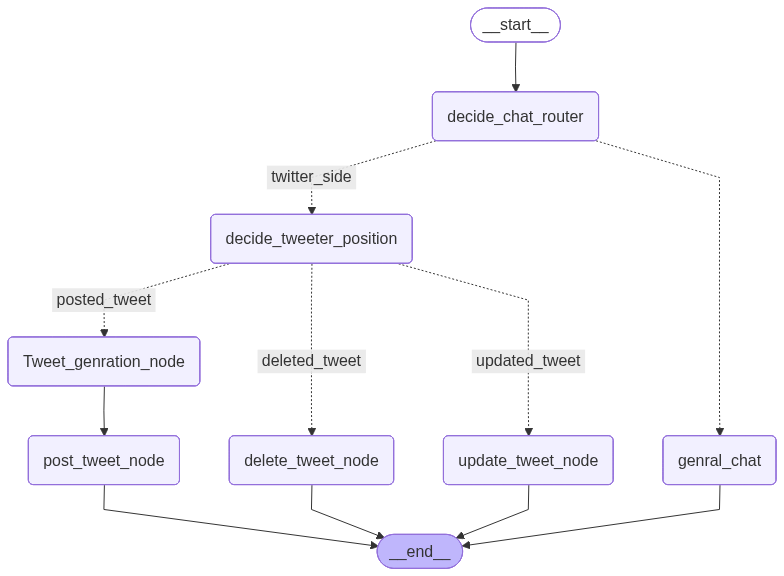

In [124]:
from IPython.display import Image,display

try:
  display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [125]:
configurable = {
    'configurable' : {'thread_id':"1011111"}
}

In [129]:
initial_state = {
    "topic": [],
    "genrated_tweet": [],
    "posted_tweet": {},
    "deleted_tweet": [],
    "updated_tweet": {},
    "tweet_id": [],
    "node_call": None,
    "messages": []
}

while True:
    question = input("Ask me anything: ")
    if question.lower() == "exit":
        break
    initial_state["topic"].append(question)
    result = workflow.invoke(initial_state, config=configurable)
    last_msg = result["messages"][-1]
    if isinstance(last_msg, AIMessage):
        print(last_msg.content)

Ask me anything: hello what is my name?
Your name is Waris.
Ask me anything: what postes i made earlier?
Tweet posted successfully! URL: https://twitter.com/user/status/1978556297717903658
Ask me anything: delete the last post 
Tweet deleted successfully! URL: https://twitter.com/user/status/1978556297717903658
Ask me anything: till now the post is not deleted ,delet it
No posted tweet to delete.
Ask me anything: write something on fishing
"The quiet patience of fishing, the thrill of the catch, and the serenity of the water. There's nothing quite like it. 🎣"
Ask me anything: what are the best way to do practise the soccer
To practice soccer effectively, focus on these key areas:

1.  **Ball Control & Dribbling:** Practice dribbling with both feet, changing pace and direction. Use cones for drills.
2.  **Passing & Receiving:** Work on short and long passes with accuracy, using different parts of your foot. Practice receiving passes cleanly.
3.  **Shooting:** Develop power and accuracy 